In [1]:
import warnings
warnings.filterwarnings('ignore',category=FutureWarning)
warnings.filterwarnings('ignore',category=DeprecationWarning)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, KFold
import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
import math
import time

In [2]:
data = pd.read_excel('~/datasets/Dataset.xlsx', sheet_name=['Total Consumers'])
df = data['Total Consumers']
df

,0,1,2,3,4,5,6,7,8,9,...,41,42,43,44,45,46,47,48,49,50
0,2.964,2.322959,1.544607,0.778310,1.962012,2.677445,0.237877,0.689194,0.358525,0.814643,...,0.898895,0.203825,0.221624,0.319531,0.830996,0.924987,0.219128,0.274880,0.990488,0.779475
1,2.584,2.371797,1.544607,0.778310,1.962012,2.733737,0.192929,0.558967,0.358525,0.660712,...,0.917793,0.165311,0.179747,0.319531,0.848467,0.944434,0.177722,0.222940,1.011313,0.795863
2,3.071,2.415961,1.319880,0.665072,1.676555,2.784640,0.382869,1.109272,0.377198,1.311186,...,0.934883,0.328060,0.356708,0.336174,0.864266,0.962019,0.352691,0.442426,1.030144,0.810682
3,2.694,2.302538,1.319880,0.665072,1.676555,2.653908,0.442052,1.280743,0.377198,1.513868,...,0.890992,0.378772,0.411848,0.336174,0.823691,0.916855,0.407209,0.510816,0.981781,0.772623
4,2.569,2.363063,0.913154,0.460128,1.159919,2.723669,0.192242,0.556976,0.668500,0.658358,...,0.914413,0.164722,0.179106,0.595793,0.845343,0.940956,0.177089,0.222146,1.007588,0.792932
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35131,1.664,2.244719,1.455982,0.733653,1.849437,2.587266,0.205654,0.595835,0.171793,0.704291,...,0.868619,0.176214,0.191602,0.153109,0.803007,0.893832,0.189444,0.237645,0.957128,0.753222
35132,1.659,2.136340,1.201186,0.605264,1.525786,2.462348,0.201219,0.582985,0.067223,0.689101,...,0.826680,0.172414,0.187470,0.059912,0.764237,0.850676,0.185359,0.232519,0.910916,0.716855
35133,1.664,2.192805,1.201186,0.605264,1.525786,2.527430,0.228585,0.662271,0.067223,0.782819,...,0.848530,0.195862,0.212966,0.059912,0.784436,0.873160,0.210568,0.264142,0.934992,0.735802
35134,1.697,1.446083,0.259545,0.130782,0.329682,1.666757,0.189302,0.548459,0.070958,0.648292,...,0.559578,0.162203,0.176368,0.063241,0.517310,0.575820,0.174381,0.218749,0.616596,0.485237


In [16]:
df_location = pd.read_pickle("~/datasets/df_location.pkl")
df_location.reset_index(drop=True, inplace=True)
df_location = df_location.iloc[:, [0, 2, 1]]
df_location

,Time,Location,Energy
0,2019-01-01 00:00:00,0,2.964000
1,2019-01-01 00:15:00,0,2.584000
2,2019-01-01 00:30:00,0,3.071000
3,2019-01-01 00:45:00,0,2.694000
4,2019-01-01 01:00:00,0,2.569000
...,...,...,...
1791931,2020-01-01 22:45:00,50,0.753222
1791932,2020-01-01 23:00:00,50,0.716855
1791933,2020-01-01 23:15:00,50,0.735802
1791934,2020-01-01 23:30:00,50,0.485237


In [17]:
num_samples_per_house = df_location.Location.value_counts()
num_houses = df_location.Location.nunique()

In [19]:
def no_ml_predict(X: np.array, y: np.array):
    mse = truncate_metric(mean_squared_error(X, y))
    #wape = mean_absolute_error(X,y) / y.mean()
    wape = truncate_metric(float(np.sum(np.abs(X - y)) / np.sum(np.abs(y))))
    r2 = truncate_metric(r2_score(X, y))
    
    print('MSE: %.4f' % mse)
    print('WAPE: %.2f' % (wape * 100))
    print('R2: %.4f' % r2)
    return mse, wape, r2


def truncate_metric(metric):
    m = math.trunc(10000*metric) / 10000
    return m

def truncate(df):
    trunc = lambda x: math.trunc(10000*x) / 10000
    df_trunc = df.applymap(trunc)
    return df_trunc

def truncate_location(df):
    trunc = lambda x: math.trunc(10000*x) / 10000
    df_trunc = pd.DataFrame(df['Energy']).applymap(trunc)
    df = pd.concat([df.iloc[:,0:-1], df_trunc],axis=1)
    return df
    
def plot_results(preds: np.array, actuals: np.array, title: str):
    
    plt.scatter(actuals, preds, c='b', label='predicted')
    plt.xlabel('actual')
    plt.ylabel('predicted')
    plt.title(title)
    plt.xlim(0, plt.xlim()[1])
    plt.ylim(0, plt.ylim()[1])
    _ = plt.plot([0, 100], [0, 100], '--r', label='y=x')
    plt.legend()
    plt.show()
    
def total_averaged_metrics(metrics_list):
    mse = np.round(sum(i for i, j, k in metrics_list)/len(metrics_list),3)
    wape = np.round(sum(j for i, j, k in metrics_list)/len(metrics_list),3)
    r2 = np.round(sum(k for i, j, k in metrics_list)/len(metrics_list),3)
    print("Total Averaged MSE: {}".format(mse))
    print("Total Averaged WAPE: {}".format(wape * 100))
    print("Total Averaged R2: {}".format(r2))
    return mse, wape, r2

In [20]:
def normalize_training(X_train):
    scaler = MinMaxScaler(feature_range=(0,1))
    scaler.fit(X_train)
    X_train = scaler.transform(X_train)
    return X_train, scaler

In [21]:
df_total = pd.DataFrame(df.sum(axis=1))
df_total.columns = ['Energy']
df_total

,Energy
0,55.550142
1,54.991249
2,59.940688
3,60.041722
4,60.835029
...,...
35131,47.547311
35132,41.480892
35133,42.935341
35134,27.259084


## Individual 51 houses preprocessing
### Previous 15 minutes

In [22]:
X15 = df_location.copy()
for i in range(1, num_houses):
    X15.iloc[(num_samples_per_house*i)-1] = np.nan
X15.dropna(inplace=True)
m = len(X15)
X15 = X15.iloc[0:(m-1)]
X15.drop(["Time", "Location"],inplace=True, axis=1)
X15.reset_index(drop=True, inplace=True)
X15

,Energy
0,2.964000
1,2.584000
2,3.071000
3,2.694000
4,2.569000
...,...
1791880,1.099100
1791881,0.753222
1791882,0.716855
1791883,0.735802


In [23]:
y15 = df_location.copy()
for i in range(1, num_houses):
    y15.iloc[(num_samples_per_house*i)] = np.nan
y15.dropna(inplace=True)
y15 = y15.iloc[1:].reset_index(drop=True)
y15.drop(["Time", "Location"],inplace=True, axis=1)
y15.reset_index(drop=True, inplace=True)
y15

,Energy
0,2.584000
1,3.071000
2,2.694000
3,2.569000
4,3.174000
...,...
1791880,0.753222
1791881,0.716855
1791882,0.735802
1791883,0.485237


### Previous day at same hour

In [24]:
Xday = df_location.copy()
for i in range(1, num_houses):
    Xday.iloc[(num_samples_per_house*i)-1] = np.nan
Xday.dropna(inplace=True)
m = len(Xday)
Xday = Xday.iloc[0:(m-96)]
Xday.drop(["Time", "Location"],inplace=True, axis=1)
Xday.reset_index(drop=True, inplace=True)
Xday

,Energy
0,2.964000
1,2.584000
2,3.071000
3,2.694000
4,2.569000
...,...
1791785,0.641933
1791786,0.752850
1791787,0.935428
1791788,0.715781


In [25]:
yday = df_location.copy()
for i in range(1, num_houses):
    yday.iloc[(num_samples_per_house*i)] = np.nan
yday.dropna(inplace=True)
yday = yday.iloc[96:].reset_index(drop=True)
yday.drop(["Time", "Location"],inplace=True, axis=1)
yday.reset_index(drop=True, inplace=True)
yday

,Energy
0,3.054000
1,2.677000
2,3.522000
3,2.729000
4,2.368000
...,...
1791785,0.753222
1791786,0.716855
1791787,0.735802
1791788,0.485237


### Previous week same day and same hour

In [26]:
Xweek = df_location.copy()
for i in range(1, num_houses):
    Xweek.iloc[(num_samples_per_house*i)-1] = np.nan
Xweek.dropna(inplace=True)
m = len(Xweek)
Xweek = Xweek.iloc[0:(m-672)]
Xweek.drop(["Time", "Location"],inplace=True, axis=1)
Xweek.reset_index(drop=True, inplace=True)
Xweek

,Energy
0,2.964000
1,2.584000
2,3.071000
3,2.694000
4,2.569000
...,...
1791209,1.723943
1791210,1.482914
1791211,1.772033
1791212,2.535657


In [27]:
yweek = df_location.copy()
for i in range(1, num_houses):
    yweek.iloc[(num_samples_per_house*i)] = np.nan
yweek.dropna(inplace=True)
yweek = yweek.iloc[672:].reset_index(drop=True)
yweek.drop(["Time", "Location"],inplace=True, axis=1)
yweek.reset_index(drop=True, inplace=True)
yweek

,Energy
0,4.940000
1,4.149000
2,4.401000
3,4.431000
4,3.988000
...,...
1791209,0.753222
1791210,0.716855
1791211,0.735802
1791212,0.485237


## Prediction organized by location
### Previous 15 minutes

In [28]:
mse_15, wape_15, r2_15 = no_ml_predict(X15.values, y15.values)

MSE: 0.2232
WAPE: 28.67
R2: 0.8098


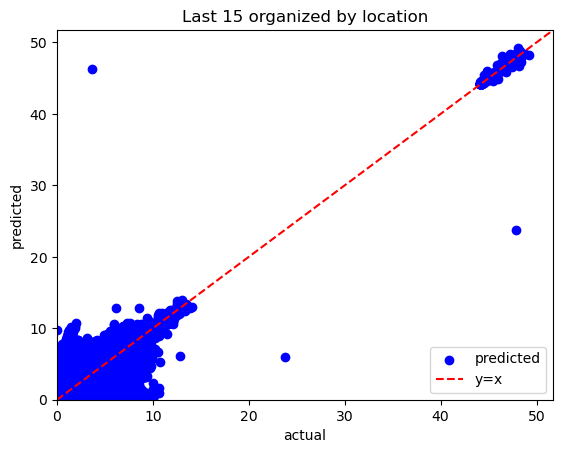

In [29]:
plot_results(X15, y15, "Last 15 organized by location")

### Previous day at same hour

In [30]:
mse_day, wape_day, r2_day = no_ml_predict(Xday.values, yday.values)

MSE: 0.8630
WAPE: 60.26
R2: 0.2648


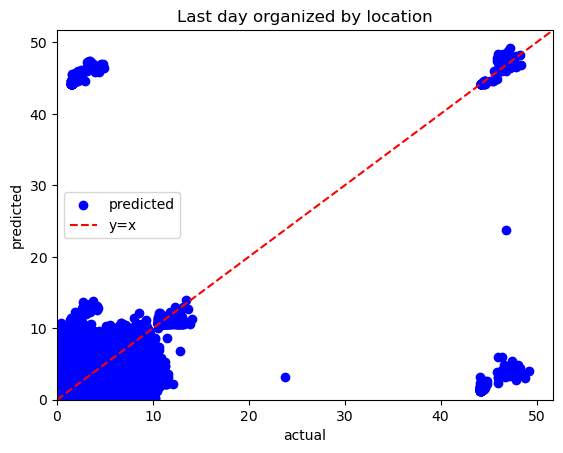

In [31]:
plot_results(Xday, yday, "Last day organized by location")

### Previous week same day and same hour

In [32]:
mse_week, wape_week, r2_week = no_ml_predict(Xweek.values, yweek.values)

MSE: 1.1994
WAPE: 65.60
R2: -0.0214


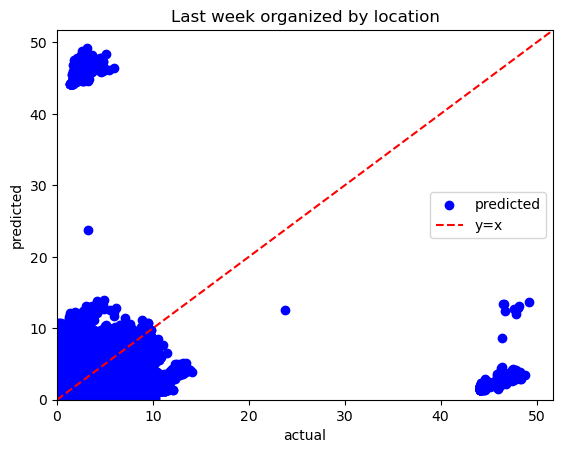

In [33]:
plot_results(Xweek, yweek, "Last week organized by location")

# Sum of all houses preprocessing
### Previous 15 minutes prediction data

In [34]:
X_total_15 = df_total.copy()
m = len(X_total_15)
X_total_15 = X_total_15.iloc[0:(m-1)]
X_total_15

,Energy
0,55.550142
1,54.991249
2,59.940688
3,60.041722
4,60.835029
...,...
35130,60.972645
35131,47.547311
35132,41.480892
35133,42.935341


In [35]:
y_total_15 = df_total.copy()
y_total_15 = y_total_15.iloc[1:].reset_index(drop=True)
y_total_15

,Energy
0,54.991249
1,59.940688
2,60.041722
3,60.835029
4,60.536440
...,...
35130,47.547311
35131,41.480892
35132,42.935341
35133,27.259084


### Previous day at same hour prediction data

In [ ]:
X_total_prev_day = df_total.copy()
m = len(X_total_prev_day)
X_total_prev_day = X_total_prev_day.iloc[0:(m-96)]
X_total_prev_day

In [ ]:
y_total_prev_day = df_total.copy()
y_total_prev_day = y_total_prev_day.iloc[96:].reset_index(drop=True)
y_total_prev_day[:15]

### Previous week same day at same hour prediction data

In [ ]:
X_total_prev_week = df_total.copy()
m = len(X_total_prev_week)
X_total_prev_week = X_total_prev_week.iloc[0:(m-96*7)]
X_total_prev_week

In [ ]:
y_total_prev_week = df_total.copy()
y_total_prev_week = y_total_prev_week.iloc[(96*7):].reset_index(drop=True)
y_total_prev_week

In [ ]:
X_total_prev_week_norm, scaler = normalize_training(X_total_prev_week)
y_total_prev_week_norm = scaler.transform(y_total_prev_week)

## Prediction (sum of all houses)

#### R2 will be negative whenever your model's predictions are worse than a constant function that always predicts the mean of the data.

### Previous 15 minutes prediction data

In [ ]:
mse_total_15_norm, wape_total_15_norm, r2_total_15_norm = no_ml_predict(X_total_15_norm, y_total_15_norm)

In [ ]:
mse_total_15, wape_total_15, r2_total_15 = no_ml_predict(X_total_15, y_total_15)

In [ ]:
plot_results(X_total_15, y_total_15, "Last 15 sum")

### Previous day at same hour prediction data

In [ ]:
mse_total_prev_day_norm, wape_total_prev_day_norm, r2_total_prev_day_norm = no_ml_predict(X_total_prev_day_norm, y_total_prev_day_norm)

In [ ]:
mse_total_prev_day, wape_total_prev_day, r2_total_prev_day = no_ml_predict(X_total_prev_day, y_total_prev_day)

In [ ]:
plot_results(X_total_prev_day, y_total_prev_day, "Last day sum")

### Previous week same day at same hour prediction data

In [ ]:
mse_total_prev_week_norm, wape_total_prev_week_norm, r2_total_prev_week_norm = no_ml_predict(X_total_prev_week_norm, y_total_prev_week_norm)

In [ ]:
mse_total_prev_week, wape_total_prev_week, r2_total_prev_week = no_ml_predict(X_total_prev_week, y_total_prev_week)

In [ ]:
plot_results(X_total_prev_week, y_total_prev_week, "Last week sum")

## Comparison between individual and sum

In [ ]:
X_names = ("MSE", "WAPE", "R2")
X_axis = np.arange(len(X_names))
plt.bar(X_axis - 0.2, (mse_15_norm, wape_15, r2_15), 0.4, label = 'Location')
plt.bar(X_axis + 0.2, (mse_total_15_norm, wape_total_15, r2_total_15), 0.4, label = 'Sum')
plt.xticks(X_axis, X_names)
plt.xlabel("By Location vs Aggregated")
plt.ylabel("Metrics")
plt.ylim(top=1)
plt.title("Organized by location average vs Energy sum (previous 15 minutes)")
plt.legend()
plt.show()

In [ ]:
plt.bar(X_axis - 0.2, (mse_day_norm, wape_day, r2_day), 0.4, label = 'Individual')
plt.bar(X_axis + 0.2, (mse_total_prev_day_norm, wape_total_prev_day, r2_total_prev_day), 0.4, label = 'Sum')
plt.xticks(X_axis, X_names)
plt.xlabel("Individual vs Sum")
plt.ylabel("Metrics")
plt.ylim(top=1)
plt.title("Individual average vs Energy sum (previous day)")
plt.legend()
plt.show()

In [ ]:
plt.bar(X_axis - 0.2, (mse_week_norm, wape_week, r2_week), 0.4, label = 'Individual')
plt.bar(X_axis + 0.2, (mse_total_prev_week_norm, wape_total_prev_week, r2_total_prev_week), 0.4, label = 'Sum')
plt.xticks(X_axis, X_names)
plt.xlabel("Individual vs Sum")
plt.ylabel("Metrics")
plt.ylim(top=1)
plt.title("Individual average vs Energy sum (previous week)")
plt.legend()
plt.show()

In [ ]:
names_alg = ["No ML - Previous 15\n", "No ML - Previous Day\n", "No ML - Previous Week\n"]
all_metrics = [(mse_15, wape_15, r2_15), (mse_day, wape_day, r2_day), (mse_week, wape_week, r2_week)]
all_metrics_agg = [(mse_total_15_norm, wape_total_15, r2_total_15), (mse_total_prev_day_norm, wape_total_prev_day, r2_total_prev_day), (mse_total_prev_week_norm, wape_total_prev_week, r2_total_prev_week)]

In [ ]:
with open('gpu_logs/no_ml.txt', 'w') as file:
    for i in range(0, 3):
        file.write(names_alg[i])
        file.write("No_ML\n")
        mse_msg = "MSE: " + str(all_metrics[i][0]) + "\n"
        wape_msg = "WAPE: " + str(all_metrics[i][1]) + "\n"
        r2_msg = "R2: " + str(all_metrics[i][2]) + "\n"
        file.write(mse_msg)
        file.write(wape_msg)
        file.write(r2_msg)
        file.write("No_ML_Aggregated\n")
        mse_msg_agg = "MSE: " + str(all_metrics_agg[i][0]) + "\n"
        wape_msg_agg = "WAPE: " + str(all_metrics_agg[i][1]) + "\n"
        r2_msg_agg = "R2: " + str(all_metrics_agg[i][2]) + "\n"
        file.write(mse_msg_agg)
        file.write(wape_msg_agg)
        file.write(r2_msg_agg)